# Preparations

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
np.random.seed(123)

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this notebook, we will predict the star-rating of Amazon book reviews based on the textual data of the reviews. First, let´s load the data and have a look at it:

In [0]:
!cp "/content/drive/My Drive/Colab Notebooks/data/MC2.csv" "MC2.csv"
minidata = pd.read_csv("MC2.csv")
minidata = minidata.drop('Unnamed: 0', axis=1)
minidata = minidata.dropna()
minidata.head()

,product_id,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
0,0983797706,Igniting Your True Purpose and Passion: A Busi...,5,0,0,N,This is an inspirational and insightful book t...,This is an inspirational and insightful book t...
1,1423151283,The Duckling Gets a Cookie!? (Pigeon),5,0,0,N,Loved it!,My twins are 3 and they love the pigeon books!...
2,1445604752,Spitfire Ace of Aces: The Wartime Story of Joh...,4,2,2,N,Engaging Account of the Combat Career of an RA...,"Back in 1964, I was introduced to 'Johnnie' Jo..."
3,0393057941,The Bread Bible,5,0,0,N,Great book for beginners,I disagree with those reviews that say this is...
4,1608322858,Do It Well. Make It Fun.: The Key to Success i...,3,2,2,N,Left me wanting more,"Reading this book, I hoped to find more about ..."


Now, we need to extract the variables we are interested in, i.e. the the two variables containing the textual data ("review_body" and "review_headline") and the target variable "star_rating". We start with the variable "star_rating" by one-hot encoding it and storing it in "y". As one can easily see in the bar plot denoting the frequency of the different star ratings, the data is highly imbalanced. Around 61% of all ratings are five-star ratings.

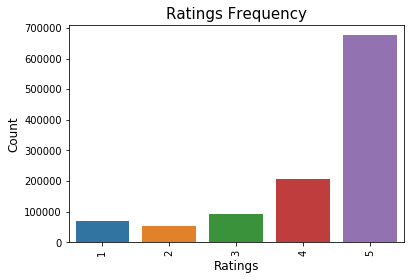

61 percent of the data belong to the majority class (five-star review).


In [0]:
y = minidata.star_rating-1
y = to_categorical(y)

plt.figure(figsize=(6,4))
sns.countplot(x="star_rating", data=minidata)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ratings', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Ratings Frequency", fontsize=15)
plt.show()

i = 0
for num in range(y.shape[0]):
  if y[num][4] == max(y[num]):
    i = i+1
i = round((i/y.shape[0])*100)
print('%s percent of the data belong to the majority class (five-star review).' % i)

After that, we move on to the next variable "review_body", to which we first add the textual data of "review_headline". The preprocessing for the textual data is somewhat more complex. As we can´t feed pure textual data to a neural network, we first need to transform each word to a number (which will be transformed to a vector via an embedding layer later on). To do this, we can use text preprocessing functions from both NLTK and Keras. First we tokenize the text, convert all letters to lowercase, remove numbers and stopwords, and use a pre-built lemmatization function. As we want to do sentiment analysis, however, we need to be careful what type of stop words we are excluding. The list of stop words from NLTK consists of words like "not" or "don't". Those type of words, however, are likely to be important for sentiment analysis, as they can totally change the sentiment of a sentence. Therefore, we create our own list of stopword based on the list of stopwords from NLTK, but excluding negating words.

After this step, we move on to the Tokenizer function from Keras. As fitting the Keras Tokenizer on text quickly blows up the RAM,  one could alternatively only use the first 100,000 reviews and assume that the most frequent words in these reviews will be somewhat similar to the most frequent words in the entire text corpus. As we do not want the network to pick up every occuring word within the text corups, we furthermore limit the maximum number of words captured by the tokenizer to 5,000, which represents approximately the 1% of the most frequent words occuring in the texts. Of course, this means that way more than 1% of the words will considered by the network as we are using the 1% most frequent words). We can calculate the 1% by looking at the maximum number of words and the lenght of the word index (representing the number of all occuring words).

After fitting the tokenizer, we can then transform each review into a sequence of numbers and pad the sequence to a length of 80 and transform the resulting sequences such that it has the right shape for the network and save them in the variable "x". We decided on a sequence lengh of 80 because when testing different values, lower values harmed the performance, while the increase of the model performance was small compared to the increase in training time needed for each epoch.

In [0]:
minidata['review_body'] = minidata['review_headline'].str.cat(minidata['review_body'],sep=" ")
x = minidata.review_body

stop_words = ['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'your','yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that',"that'll",'these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','only','own','same','so','than','too','very','s','can','will','just','now','d','ll','m','o','re','ve','y','ma']
lemmatizer = WordNetLemmatizer()
def fun_nltk(txt):
  tok = nltk.word_tokenize(txt)
  tok = [word.lower() for word in tok if word.isalpha()]
  tok = [word for word in tok if word not in stop_words]
  tok = [lemmatizer.lemmatize(word, pos='n') for word in tok]
  return tok
x = x.apply(fun_nltk)
x = x.apply(' '.join)

#x.to_pickle("/content/drive/My Drive/Colab Notebooks/x and y/xpre.pkl")

In [0]:
#0 - only for internal use to save time running the same code aganin
!cp "/content/drive/My Drive/Colab Notebooks/x and y/xpre.pkl" "xpre.pkl"
x = pd.read_pickle("xpre.pkl")

In [0]:
MAX_NB_WORDS = 5000
text_for_tokenizer = ' '.join(x)
#RAM-intensive; alternative would be: text_for_tokenizer = ' '.join(x.iloc[:TEXT_LENGHT])
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts([text_for_tokenizer])
word_index = tokenizer.word_index
print(MAX_NB_WORDS/len(word_index))
def fun1(num):
  return tokenizer.texts_to_sequences([num])
x = x.apply(fun1)
MAX_SEQUENCE_LENGTH = 80
def fun2(num):
  return pad_sequences(num, maxlen=MAX_SEQUENCE_LENGTH)
x = x.apply(fun2)
x = np.stack(x, axis=0)
x = x.reshape((x.shape[0], MAX_SEQUENCE_LENGTH))

#word_index.keys()
#word_index["word"]
#np.save("/content/drive/My Drive/Colab Notebooks/x and y/x", x)

0.009955062846311749


Now, after having defined our feature variable "x" and target variable "y", we the can create our training and test data:

In [0]:
#1 - only for internal use to save time running the same code aganin
!cp "/content/drive/My Drive/Colab Notebooks/x and y/x.npy" "x.npy"
x = np.load("x.npy")

In [0]:
#2 - only for internal use to save time running the same code aganin
!cp "/content/drive/My Drive/Colab Notebooks/x and y/y.txt" "y.txt"
y = np.loadtxt("y.txt", delimiter=",",  dtype='int')

In [0]:
#3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

Before we start training our network, however, we perform one final step. As mentioned earlier, the integer-coded words are transformed to vectors by an embedding layer. Training such a word embedding can take much time and require a lot of data. Therefore, we tried out different pre-trained word embeddings. By setting the weights of the embedding matrix to be trainable, it is also possible to use these pre-trained word embeddings as starting points rather than fixed embeddings (see for more details in the training section).

The first one was the GloVe word embedding from Stanford University, which was created by implementing a popular embedding technique based on matrix factorization of word co-occurence statistics using Wikipedia articles. More specifically, we implemented the 100-dimensional version of the GloVe embedding, meaning that each word is represented by a 100-dimensional vector. After importing the pretrained word embeddings, we create the embedding matrix (which will be fed to the embedding layer as its trainable/non-trainable weights later on) based on the imported embeddings and our tokenizer which we had fitted before. When inputting an one-hot-encoded word, the embedding layer outputs the respective 100-dimensional word vector from the embedding.

As we are dealing with sentiment analysis, however, it might be a good idea to use a word embedding which were trained on product reviews. Therefore, we also implemented a 300-dimensional word embedding which was trained on Amazon reviews (see http://softeng.polito.it/erion/).

Yet, using the pretrained GloVe from Stanford university turned out to produce better results than when using the trained embeddings from a similar domain. Terefore, we will use the GloVe word embedding.


In [0]:
!cp "/content/drive/My Drive/Colab Notebooks/data/glove.6B.100d.txt" "glove.6B.100d.txt"
f = open('glove.6B.100d.txt')
embeddings_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#np.save("/content/drive/My Drive/Colab Notebooks/x and y/embedding_matrix", embedding_matrix)

In [0]:
#4 - only for internal use to save time running the same code aganin
!cp "/content/drive/My Drive/Colab Notebooks/x and y/embedding_matrix.npy" "embedding_matrix.npy"
embedding_matrix = np.load("embedding_matrix.npy")

In [0]:
#5 - only for internal use to save time running the same code aganin
MAX_SEQUENCE_LENGTH = 80
EMBEDDING_DIM = 100
#word_index = np.repeat(0, 502257)